# Anomalies Detection  

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pymongo import MongoClient


In [23]:

# Step 1: Download data
ticker = 'GME'
start_date = "2000-01-01"
end_date = "2023-12-31"

gme_data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Agar MultiIndex columns hain toh unko flatten karo
if isinstance(gme_data.columns, pd.MultiIndex):
    gme_data.columns = [col[0] for col in gme_data.columns]  # sirf pehla naam lo

# Step 3: Index reset (Date ko column banao)
gme_data.reset_index(inplace=True)

# Step 4: MongoDB connect
client = MongoClient("mongodb://localhost:27017/")
db = client["mydata"]
collection = db["mydata"]

# Step 5: Data insert
collection.delete_many({})
collection.insert_many(gme_data.to_dict("records"))

print("✅ GME data MongoDB me save ho gaya!")


C:\Users\admin\AppData\Local\Temp\ipykernel_5904\3683546522.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gme_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

✅ GME data MongoDB me save ho gaya!


In [24]:
gme_data.head()

,Date,Close,High,Low,Open,Volume
0,2002-02-13,1.691666,1.693350,1.603296,1.620128,76216000
1,2002-02-14,1.683250,1.716074,1.670626,1.712707,11021600
2,2002-02-15,1.674834,1.687459,1.658002,1.683251,8389600
3,2002-02-19,1.607504,1.666418,1.578047,1.666418,7410400
4,2002-02-20,1.662210,1.662210,1.603296,1.615920,6892800


In [25]:
gme_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5508 non-null   datetime64[ns]
 1   Close   5508 non-null   float64       
 2   High    5508 non-null   float64       
 3   Low     5508 non-null   float64       
 4   Open    5508 non-null   float64       
 5   Volume  5508 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 258.3 KB


# ploting the close price 

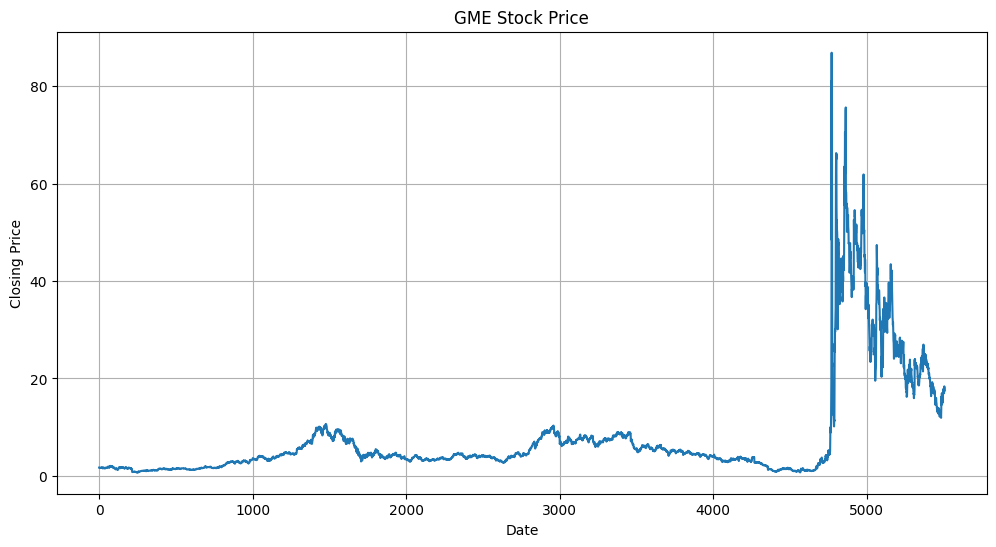

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data.index, gme_data['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


# EDA

## CALCURATE RETURN 

In [28]:
gme_data['Returns']=gme_data['Close'].pct_change()

In [29]:
gme_data.head()

,Date,Close,High,Low,Open,Volume,Returns
0,2002-02-13,1.691666,1.693350,1.603296,1.620128,76216000,NaN
1,2002-02-14,1.683250,1.716074,1.670626,1.712707,11021600,-0.004975
2,2002-02-15,1.674834,1.687459,1.658002,1.683251,8389600,-0.005000
3,2002-02-19,1.607504,1.666418,1.578047,1.666418,7410400,-0.040201
4,2002-02-20,1.662210,1.662210,1.603296,1.615920,6892800,0.034031


### calculating volality 

In [30]:
gme_data['Volatility']=gme_data['Returns'].rolling(window=20).std()

# ploting the price change volality and return 

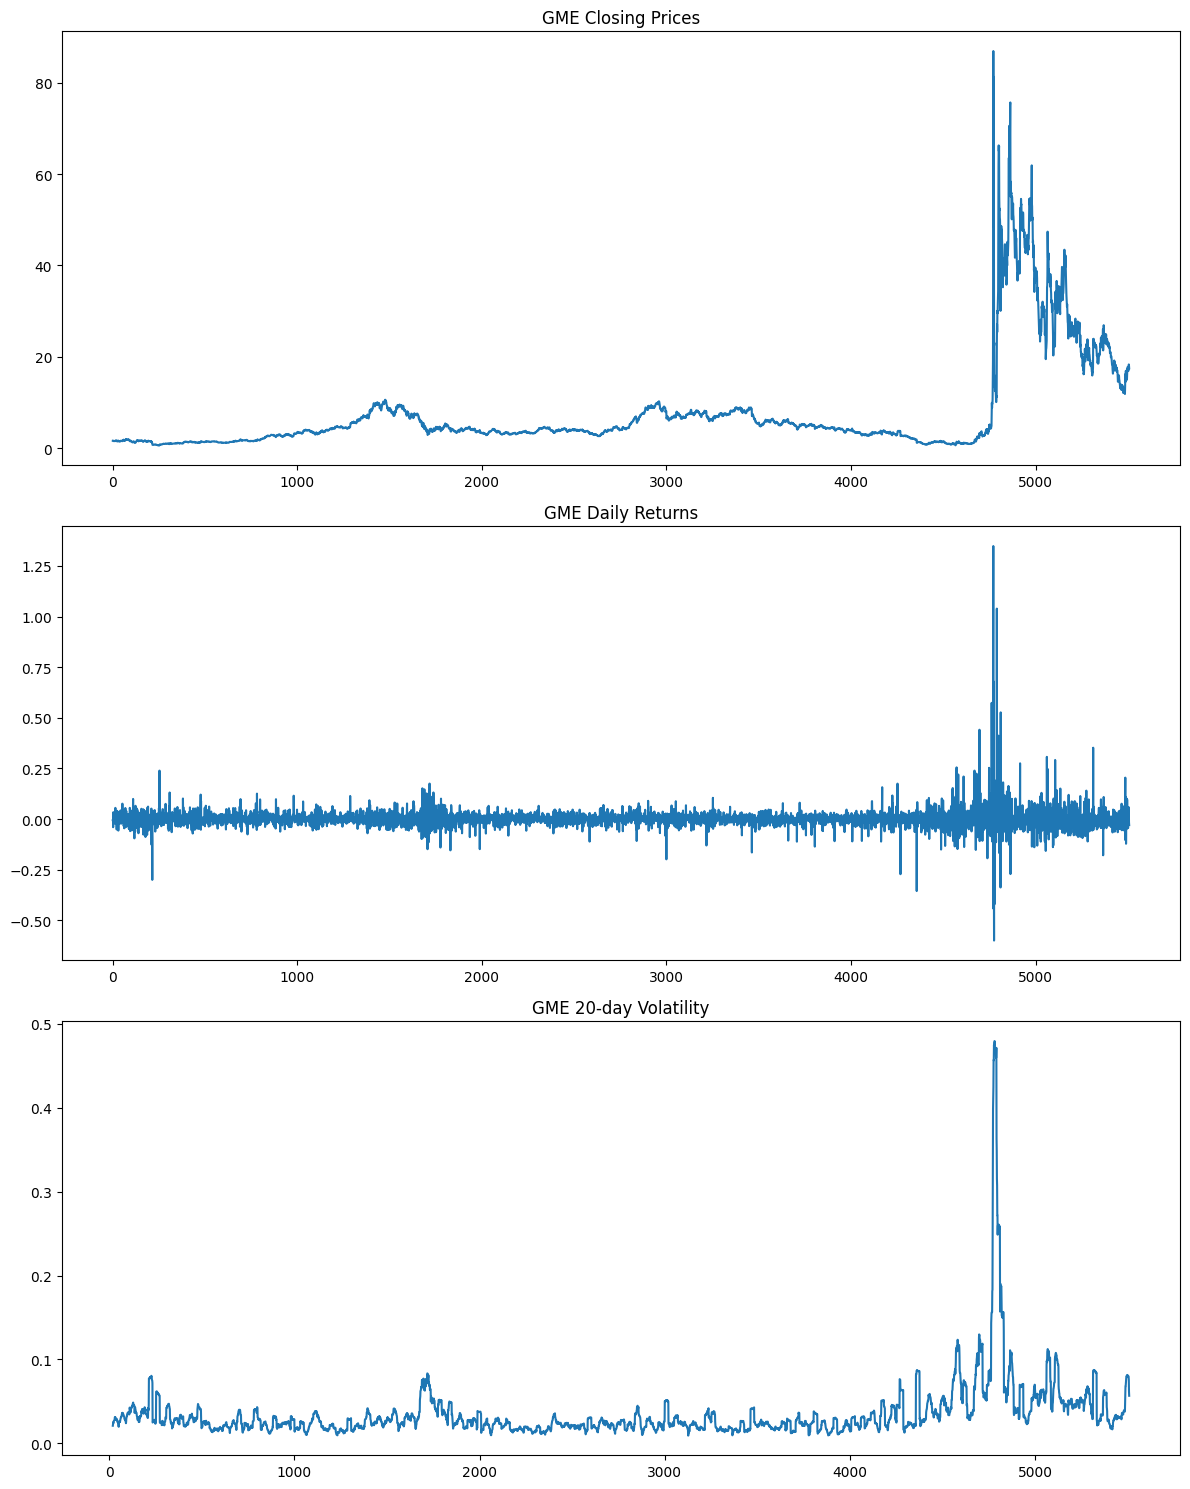

In [31]:
fig,axes=plt.subplots(3,1,figsize=(12,15))
axes[0].plot(gme_data.index, gme_data['Close'])
axes[0].set_title('GME Closing Prices')
axes[1].plot(gme_data.index, gme_data['Returns'])
axes[1].set_title('GME Daily Returns')
axes[2].plot(gme_data.index, gme_data['Volatility'])
axes[2].set_title('GME 20-day Volatility')
plt.tight_layout()

plt.show()

# Feature Engineering

simple moving average 

In [32]:
gme_data.head()

,Date,Close,High,Low,Open,Volume,Returns,Volatility
0,2002-02-13,1.691666,1.693350,1.603296,1.620128,76216000,NaN,NaN
1,2002-02-14,1.683250,1.716074,1.670626,1.712707,11021600,-0.004975,NaN
2,2002-02-15,1.674834,1.687459,1.658002,1.683251,8389600,-0.005000,NaN
3,2002-02-19,1.607504,1.666418,1.578047,1.666418,7410400,-0.040201,NaN
4,2002-02-20,1.662210,1.662210,1.603296,1.615920,6892800,0.034031,NaN


In [33]:
gme_data['SMA_10']=gme_data['Close'].rolling(window=10).mean()
gme_data['SMA_20']=gme_data['Close'].rolling(window=20).mean()

In [34]:
gme_data.head()

,Date,Close,High,Low,Open,Volume,Returns,Volatility,SMA_10,SMA_20
0,2002-02-13,1.691666,1.693350,1.603296,1.620128,76216000,NaN,NaN,NaN,NaN
1,2002-02-14,1.683250,1.716074,1.670626,1.712707,11021600,-0.004975,NaN,NaN,NaN
2,2002-02-15,1.674834,1.687459,1.658002,1.683251,8389600,-0.005000,NaN,NaN,NaN
3,2002-02-19,1.607504,1.666418,1.578047,1.666418,7410400,-0.040201,NaN,NaN,NaN
4,2002-02-20,1.662210,1.662210,1.603296,1.615920,6892800,0.034031,NaN,NaN,NaN


In [35]:
gme_data['SMA_50'] = gme_data['Close'].rolling(window=50).mean()

In [36]:
def calculate_rsi(data,periods=14):
    delta=data.diff()
    gain=(delta.where(delta>0,0)).rolling(window=periods).mean()
    loss=(-delta.where(delta<0,0)).rolling(window=periods).mean()
    rs=gain/loss
    return 100-(100/(1+rs))
gme_data['RSI']=calculate_rsi(gme_data['Close'])

In [37]:
gme_data.head()

,Date,Close,High,Low,Open,Volume,Returns,Volatility,SMA_10,SMA_20,SMA_50,RSI
0,2002-02-13,1.691666,1.693350,1.603296,1.620128,76216000,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-02-14,1.683250,1.716074,1.670626,1.712707,11021600,-0.004975,NaN,NaN,NaN,NaN,NaN
2,2002-02-15,1.674834,1.687459,1.658002,1.683251,8389600,-0.005000,NaN,NaN,NaN,NaN,NaN
3,2002-02-19,1.607504,1.666418,1.578047,1.666418,7410400,-0.040201,NaN,NaN,NaN,NaN,NaN
4,2002-02-20,1.662210,1.662210,1.603296,1.615920,6892800,0.034031,NaN,NaN,NaN,NaN,NaN


# Bollinger Bands

In [38]:
gme_data['Upper_BB']=gme_data['SMA_20']+(gme_data['Close'].rolling(window=20).std()*2)
gme_data['Lower_BB']=gme_data['SMA_20']-(gme_data['Close'].rolling(window=20).std()*2)

# plot tecnical analysis 

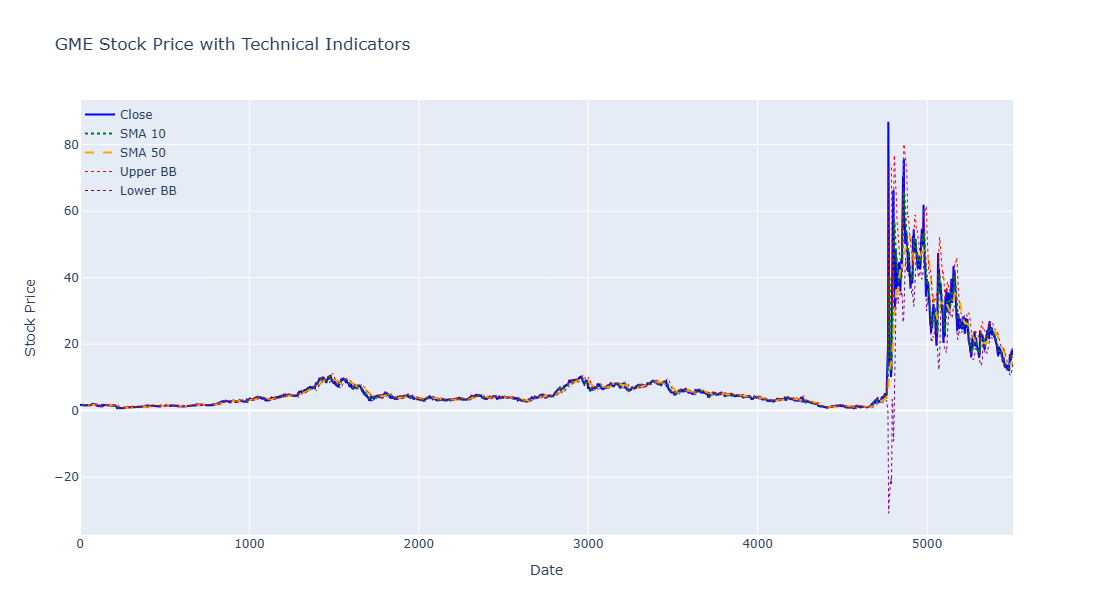

In [39]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add 'Close' price line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Close'],
    mode='lines',
    name='Close',
    line=dict(color='blue', width=2)
))

# Add 'SMA 10' line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['SMA_10'],
    mode='lines',
    name='SMA 10',
    line=dict(color='green', width=2, dash='dot')
))

# Add 'SMA 50' line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['SMA_50'],
    mode='lines',
    name='SMA 50',
    line=dict(color='orange', width=2, dash='dash')
))

# Add 'Upper BB' line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Upper_BB'],
    mode='lines',
    name='Upper BB',
    line=dict(color='red', width=1, dash='dot')
))

# Add 'Lower BB' line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Lower_BB'],
    mode='lines',
    name='Lower BB',
    line=dict(color='purple', width=1, dash='dot')
))

# Update layout for a larger figure size and title
fig.update_layout(
    title='GME Stock Price with Technical Indicators',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    legend=dict(x=0, y=1, bgcolor='rgba(255,255,255,0)', bordercolor='rgba(255,255,255,0)'),
    autosize=False,
    width=1200,
    height=600,
   
)

# Show the plot
fig.show()


# Anomaly Detection Techniques

## stats mode 

# apllying z score model 


In [40]:
from scipy import stats

In [41]:
gme_data['Close_Z_Score']=stats.zscore(gme_data['Close'])
anomlies_zscore=gme_data[abs(gme_data['Close_Z_Score'])>3]


In [42]:
anomlies_zscore

,Date,Close,High,Low,Open,Volume,Returns,Volatility,SMA_10,SMA_20,SMA_50,RSI,Upper_BB,Lower_BB,Close_Z_Score
4771,2021-01-27,86.877502,95.000000,62.250000,88.707497,373586800,1.348358,0.376478,21.64025,13.146625,7.52745,98.434327,51.142634,-24.849384,7.540914
4772,2021-01-28,48.400002,120.750000,28.062500,66.250000,235263200,-0.442894,0.398567,25.69525,15.324375,8.44040,67.786065,56.200545,-25.551794,3.873148
4773,2021-01-29,81.250000,103.495003,62.500000,94.927498,202264400,0.678719,0.411380,32.82250,19.146125,10.00510,74.607241,69.157106,-30.864856,7.004488
4774,2021-02-01,56.250000,80.500000,53.000000,79.139999,149528800,-0.307692,0.424593,37.56000,21.723125,11.07195,64.197291,73.868052,-30.421802,4.621429
4798,2021-03-08,48.625000,52.717499,36.525002,38.722500,254262400,0.412081,0.259159,29.36250,20.778000,19.09480,89.547759,42.766949,-1.210949,3.894596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2022-08-11,39.450001,41.970001,39.349998,40.910000,5140500,-0.026647,0.043996,38.47400,37.130000,34.45055,59.818091,42.980300,31.279699,3.020013
5160,2022-08-12,40.740002,41.430000,39.150002,40.000000,5120000,0.032700,0.043751,39.14700,37.396500,34.65835,68.591865,43.400478,31.392522,3.142979
5161,2022-08-15,39.680000,40.389999,38.810001,39.750000,5243100,-0.026019,0.043882,39.63700,37.547500,34.78195,70.491800,43.624943,31.470057,3.041937
5162,2022-08-16,42.189999,45.529999,38.599998,39.169998,23602800,0.063256,0.045350,40.27200,37.760750,34.95725,72.307689,44.183465,31.338035,3.281196


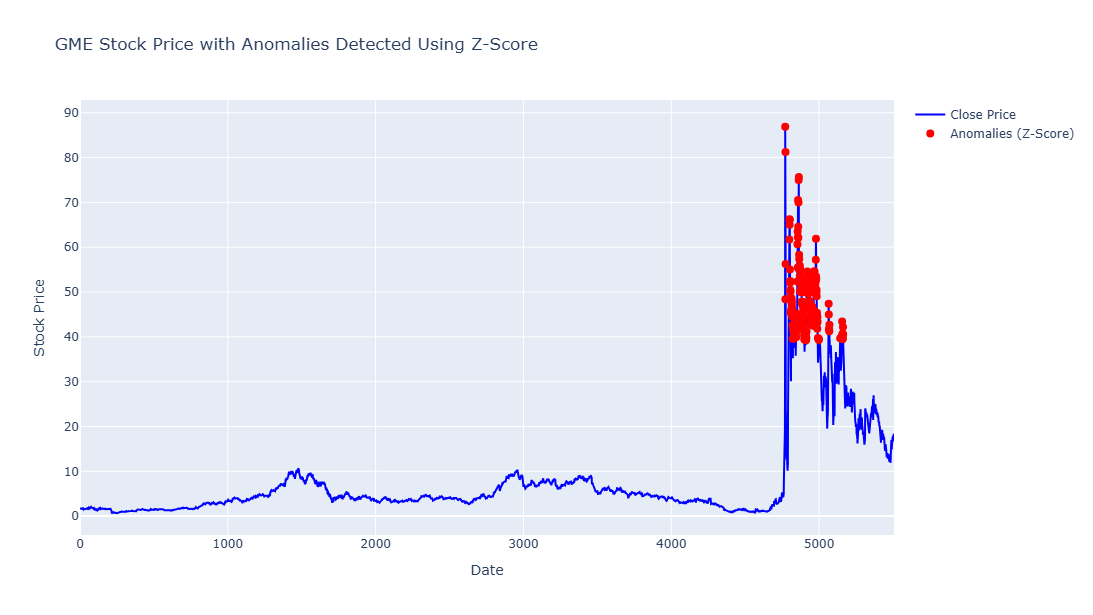

In [43]:
import plotly.graph_objects as go
from scipy import stats

# Calculate Z-Score for 'Close' prices
gme_data['Close_Z_Score'] = stats.zscore(gme_data['Close'])

# Identify anomalies where Z-Score > 3 or < -3
anomalies_zscore = gme_data[abs(gme_data['Close_Z_Score']) > 3]

# Create the figure
fig = go.Figure()

# Add 'Close' price line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='blue', width=2)
))

# Add anomalies (Z-score > 3 or < -3) as red markers
fig.add_trace(go.Scatter(
    x=anomalies_zscore.index,
    y=anomalies_zscore['Close'],
    mode='markers',
    name='Anomalies (Z-Score)',
    marker=dict(color='red', size=8, symbol='circle'),
    showlegend=True
))

# Update layout for a larger figure size and title
fig.update_layout(
    title='GME Stock Price with Anomalies Detected Using Z-Score',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    autosize=False,
    width=1200,
    height=600,
    
)

# Show the plot
fig.show()


# machine learing methods 

# isolation forest  approch 

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

In [46]:
gme_data[['Close','Volume','Returns','Volatility']].isna().sum()

Close          0
Volume         0
Returns        1
Volatility    20
dtype: int64

In [47]:
gme_data = gme_data.dropna(subset=['Close', 'Volume', 'Returns', 'Volatility'])

In [48]:
scaler=StandardScaler()
X=scaler.fit_transform(gme_data[['Close','Volume','Returns','Volatility']])
iso_forest=IsolationForest(contamination=0.01, random_state=42)
gme_data['Anomaly_IsoForest']=iso_forest.fit_predict(X)


In [49]:
anomalies_iso = gme_data[gme_data['Anomaly_IsoForest'] == -1]

In [50]:
anomalies_iso

,Date,Close,High,Low,Open,Volume,Returns,Volatility,SMA_10,SMA_20,SMA_50,RSI,Upper_BB,Lower_BB,Close_Z_Score,Anomaly_IsoForest
4684,2020-09-22,2.640000,2.792500,2.475000,2.612500,139010000,0.206857,0.100285,2.008250,1.828375,1.37980,68.394439,2.597982,1.058768,-0.488803,-1
4696,2020-10-08,3.372500,3.410000,2.297500,2.385000,305814400,0.441239,0.125907,2.531500,2.339875,1.73940,68.474262,3.106054,1.573696,-0.418979,-1
4697,2020-10-09,3.005000,3.700000,2.975000,3.207500,308611200,-0.108970,0.129801,2.581500,2.414000,1.77900,64.058472,3.132594,1.695406,-0.454010,-1
4762,2021-01-13,7.850000,9.662500,5.007500,5.105000,578006800,0.573935,0.143319,4.953500,4.654750,3.86645,77.638890,6.516281,2.793219,0.007827,-1
4763,2021-01-14,9.977500,10.765000,8.262500,9.522500,374869600,0.271019,0.151227,5.469750,4.980500,4.01225,83.344828,7.927331,2.033669,0.210625,-1
4764,2021-01-15,8.875000,10.187500,8.502500,9.622500,187465600,-0.110499,0.155606,5.886250,5.251125,4.13190,73.264626,8.580300,1.921950,0.105532,-1
4765,2021-01-19,9.840000,11.380000,9.160000,10.387500,298887600,0.108732,0.156008,6.439000,5.557750,4.27415,75.506805,9.381245,1.734255,0.197518,-1
4767,2021-01-21,10.757500,11.187500,9.250000,9.807500,224867600,0.099949,0.156255,7.599500,6.195125,4.56835,80.926356,10.798347,1.591903,0.284976,-1
4768,2021-01-22,16.252501,19.190001,10.580000,10.647500,788631600,0.510807,0.181463,8.772750,6.764500,4.83595,88.481412,13.147844,0.381156,0.808773,-1
4769,2021-01-25,19.197500,39.794998,15.282500,24.182501,711496000,0.181203,0.182949,10.250250,7.467250,5.16440,92.419491,15.873014,-0.938514,1.089497,-1


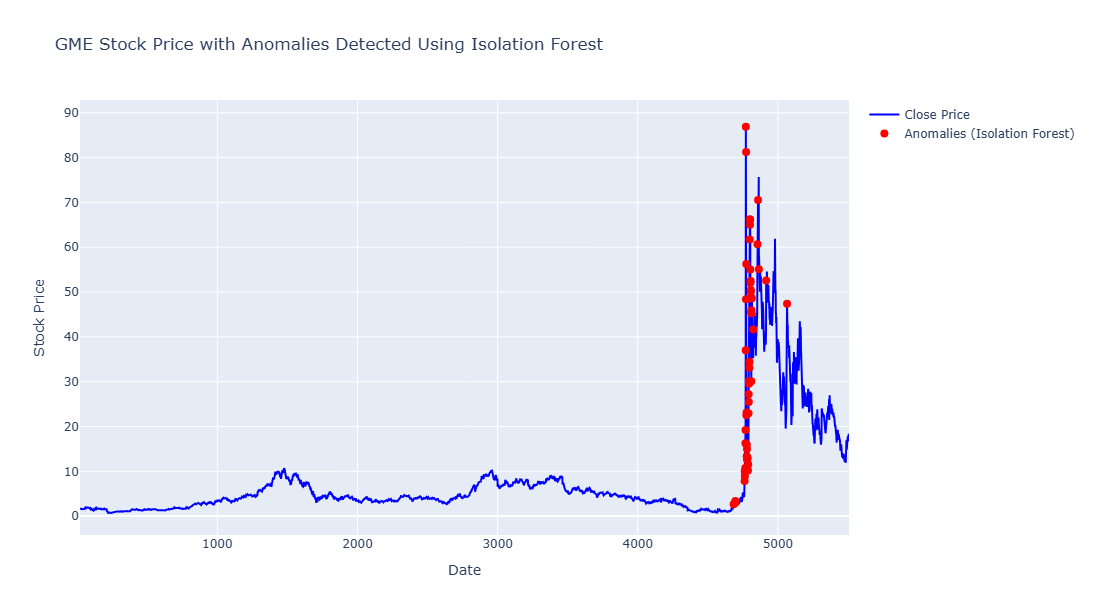

In [51]:
fig = go.Figure()

# Add Close price line
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='blue', width=2)
))

# Add anomalies (Isolation Forest) as red markers
fig.add_trace(go.Scatter(
    x=anomalies_iso.index,
    y=anomalies_iso['Close'],
    mode='markers',
    name='Anomalies (Isolation Forest)',
    marker=dict(color='red', size=8, symbol='circle'),
    showlegend=True
))

# Update layout for a larger figure size and title
fig.update_layout(
    title='GME Stock Price with Anomalies Detected Using Isolation Forest',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    autosize=False,
    width=1200,
    height=600,
   
)

# Show the plot
fig.show()

# DBSCAN

In [52]:
dbscan=DBSCAN(eps=0.5,min_samples=5)
gme_data['Anomaly_DBSCAN'] = dbscan.fit_predict(X)

In [53]:
gme_data['Color'] = gme_data['Anomaly_DBSCAN'].apply(lambda x: 'red' if x == -1 else 'blue')


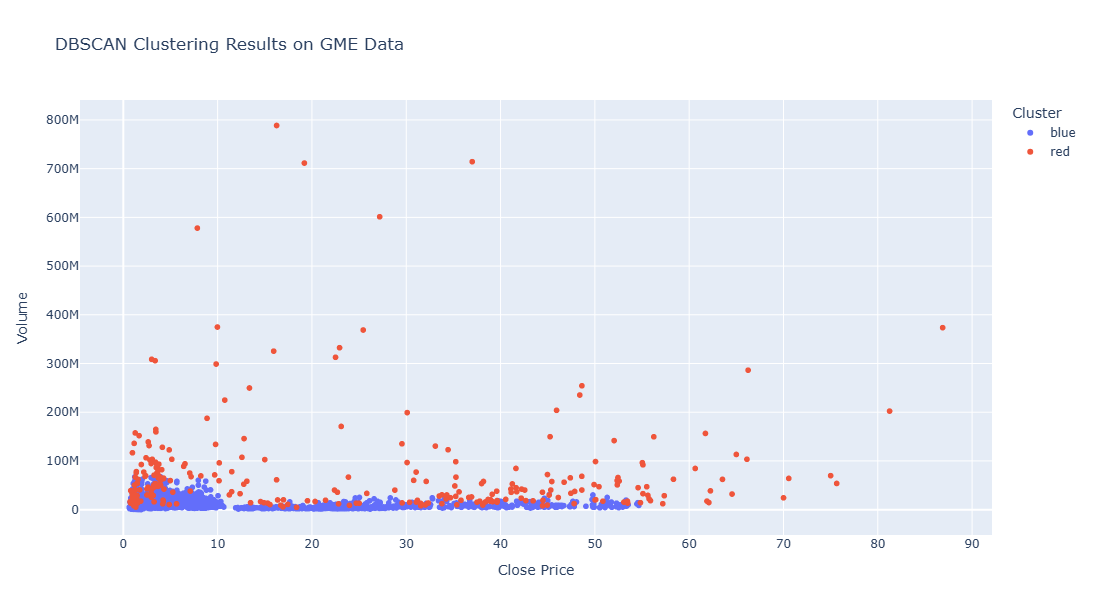

In [54]:
import plotly.express as px
fig = px.scatter(
    gme_data,
    x='Close',
    y='Volume',
    color='Color',
    title='DBSCAN Clustering Results on GME Data',
    labels={'Color': 'Cluster'},
    hover_data=['Returns', 'Volatility'],  # Add more data to hover
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Close Price',
    yaxis_title='Volume',
    legend_title='Cluster',
    autosize=False,
    width=1200,
    height=600,
)

# Show the plot
fig.show()



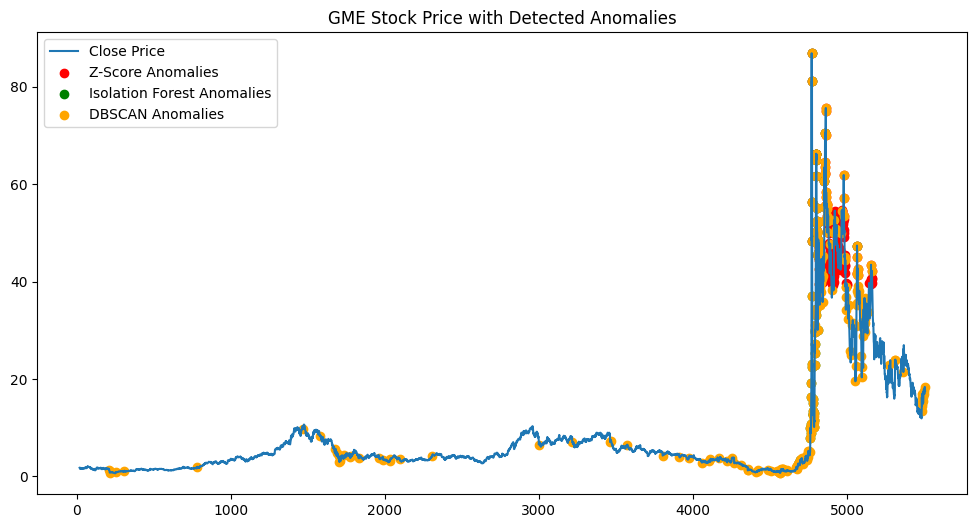

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data.index, gme_data['Close'], label='Close Price')
plt.scatter(anomalies_zscore.index, anomalies_zscore['Close'], color='red', label='Z-Score Anomalies')
plt.scatter(gme_data[gme_data['Anomaly_IsoForest'] == -1].index, 
            gme_data[gme_data['Anomaly_IsoForest'] == -1]['Close'], 
            color='green', label='Isolation Forest Anomalies')
plt.scatter(gme_data[gme_data['Anomaly_DBSCAN'] == -1].index, 
            gme_data[gme_data['Anomaly_DBSCAN'] == -1]['Close'], 
            color='orange', label='DBSCAN Anomalies')
plt.title('GME Stock Price with Detected Anomalies')
plt.legend()
plt.show()

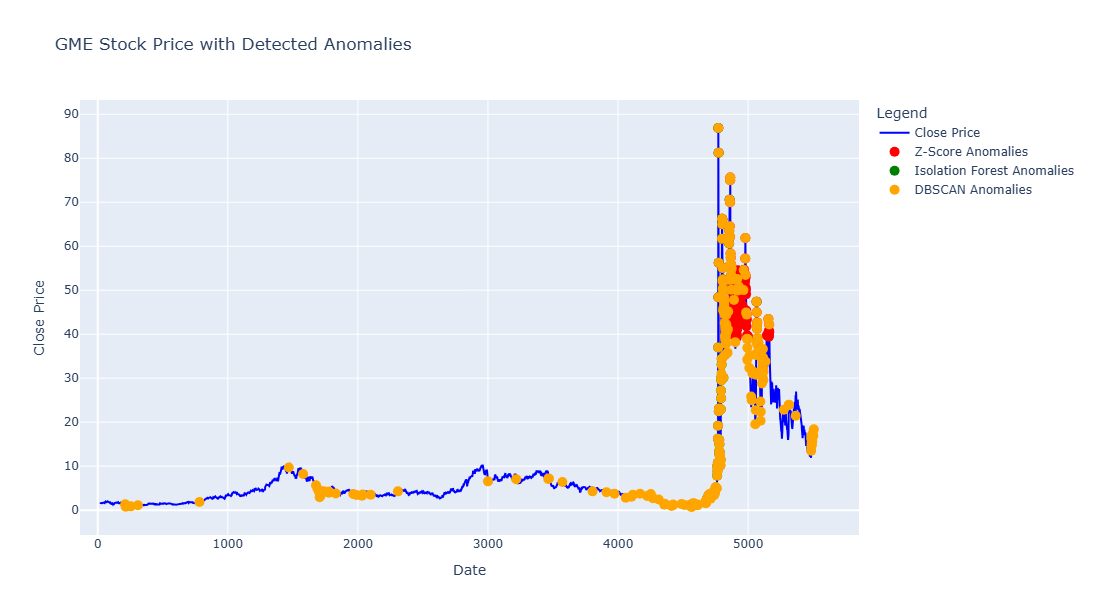

In [56]:
import plotly.graph_objects as go


fig = go.Figure()

# Add the line for the closing price
fig.add_trace(go.Scatter(
    x=gme_data.index,
    y=gme_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='blue'),
))

# Add the scatter plot for Z-Score anomalies
fig.add_trace(go.Scatter(
    x=anomalies_zscore.index,
    y=anomalies_zscore['Close'],
    mode='markers',
    name='Z-Score Anomalies',
    marker=dict(color='red', size=10),
))

# Add the scatter plot for Isolation Forest anomalies
fig.add_trace(go.Scatter(
    x=gme_data[gme_data['Anomaly_IsoForest'] == -1].index,
    y=gme_data[gme_data['Anomaly_IsoForest'] == -1]['Close'],
    mode='markers',
    name='Isolation Forest Anomalies',
    marker=dict(color='green', size=10),
))

# Add the scatter plot for DBSCAN anomalies
fig.add_trace(go.Scatter(
    x=gme_data[gme_data['Anomaly_DBSCAN'] == -1].index,
    y=gme_data[gme_data['Anomaly_DBSCAN'] == -1]['Close'],
    mode='markers',
    name='DBSCAN Anomalies',
    marker=dict(color='orange', size=10),
))

# Update layout
fig.update_layout(
    title='GME Stock Price with Detected Anomalies',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend_title='Legend',
    width=1200,
    height=600,
)

# Show the plot
fig.show()


In [57]:
print("Number of Z-Score Anomalies:", len(anomalies_zscore))
print("Number of Isolation Forest Anomalies:", sum(gme_data['Anomaly_IsoForest'] == -1))
print("Number of DBSCAN Anomalies:", sum(gme_data['Anomaly_DBSCAN'] == -1))

Number of Z-Score Anomalies: 201
Number of Isolation Forest Anomalies: 55
Number of DBSCAN Anomalies: 272


# Advance deep learning model 

# Lstm 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [66]:
from sklearn.preprocessing import StandardScaler
import numpy as np

sequence_length = 20
features = ['Close', 'Volume', 'Returns', 'Volatility']

def create_sequence(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])        # input sequence
        Y.append(data[i+sequence_length, 0])       # target = next "Close" price
    return np.array(X), np.array(Y)

# Normalize features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(gme_data[features])

# Create sequences
X, y = create_sequence(normalized_data, sequence_length)

print("X shape:", X.shape)
print("y shape:", y.shape)
    

X shape: (5468, 20, 4)
y shape: (5468,)


In [69]:
# spliting the data 

In [72]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [74]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(features))),
    Dense(1)   # <-- Sirf 1 neuron, Close price predict karega
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0554 - val_loss: 0.0212
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0019 - val_loss: 4.0560e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4581e-04 - val_loss: 4.2094e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.6315e-04 - val_loss: 2.8994e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9538e-04 - val_loss: 2.7285e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6765e-04 - val_loss: 2.5837e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7959e-04 - val_loss: 2.5796e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.1924e-04 - val_loss: 2.8593e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9534e-04 - val_loss: 3.3982e-04
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6029e-

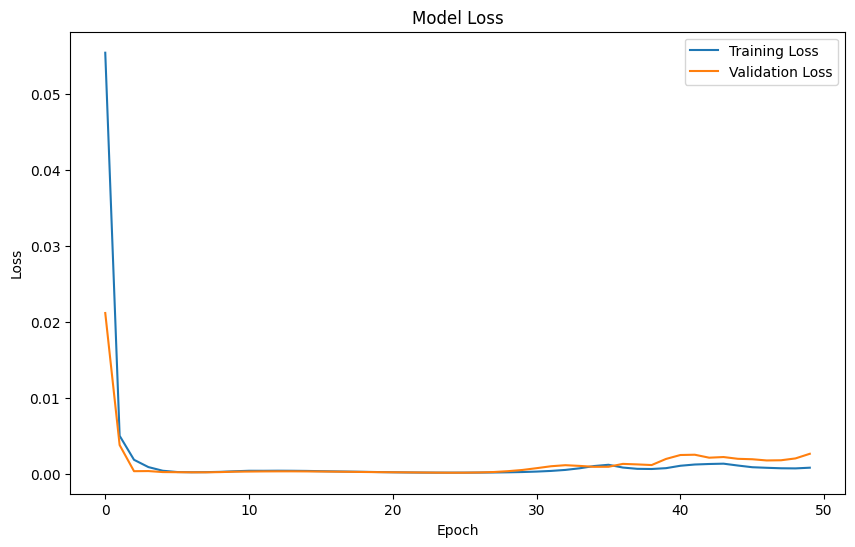

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [76]:
y_pred=model.predict(X_test)
mse=np.mean(np.power(y_test-y_pred,2),axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


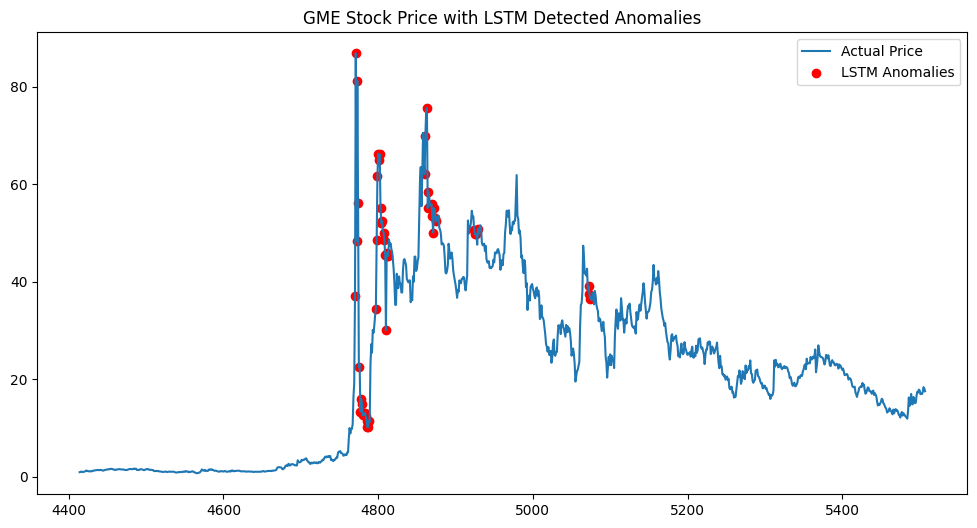

Number of LSTM Detected Anomalies: 55


In [77]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data.index[train_size+sequence_length:], gme_data['Close'][train_size+sequence_length:], label='Actual Price')
plt.scatter(gme_data.index[train_size+sequence_length:][anomalies], 
            gme_data['Close'][train_size+sequence_length:][anomalies], 
            color='red', label='LSTM Anomalies')
plt.title('GME Stock Price with LSTM Detected Anomalies')
plt.legend()
plt.show()

# Print summary of LSTM anomalies
print(f"Number of LSTM Detected Anomalies: {sum(anomalies)}")

In [78]:
y_pred=model.predict(X_test)
mse=np.mean(np.power(y_test-y_pred,2),axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


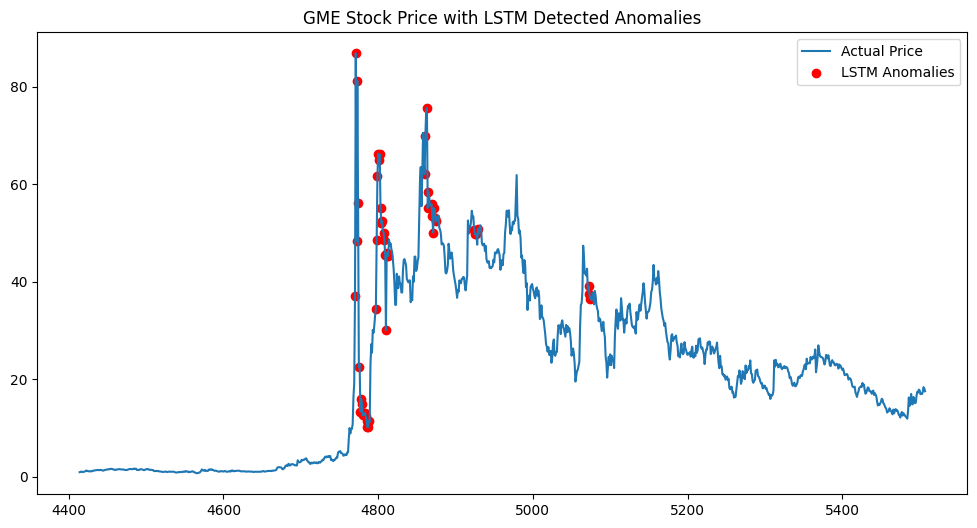

Number of LSTM Detected Anomalies: 55


In [79]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data.index[train_size+sequence_length:], gme_data['Close'][train_size+sequence_length:], label='Actual Price')
plt.scatter(gme_data.index[train_size+sequence_length:][anomalies], 
            gme_data['Close'][train_size+sequence_length:][anomalies], 
            color='red', label='LSTM Anomalies')
plt.title('GME Stock Price with LSTM Detected Anomalies')
plt.legend()
plt.show()

# Print summary of LSTM anomalies
print(f"Number of LSTM Detected Anomalies: {sum(anomalies)}")

# autoEncoder

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [81]:
# Prepare the data
features = ['Close', 'Volume', 'Returns', 'Volatility']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gme_data[features])


In [82]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [83]:
input_dim = scaled_data.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(4, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(4, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [84]:
history = autoencoder.fit(
    train_data, train_data,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1515 - val_loss: 0.1700
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1219 - val_loss: 0.1388
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0949 - val_loss: 0.1107
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0776 - val_loss: 0.0929
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0701 - val_loss: 0.0852
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0663 - val_loss: 0.0825
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0637 - val_loss: 0.0807
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0620 - val_loss: 0.0771
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0606 - val_loss: 0.0787
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0594 - val_loss: 0.0753
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - val_loss: 0.0736
Epoch 12/100
110/110 ━━━━━━━━━━━━━━━━━━━━

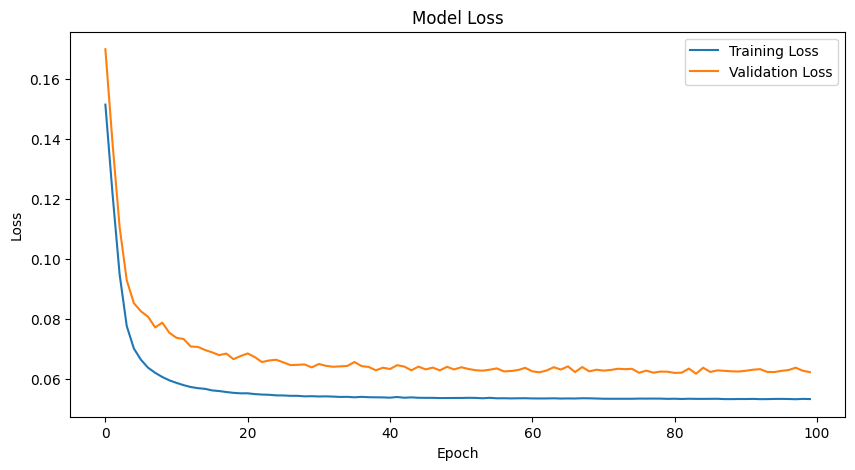

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [86]:
# Predict on the entire dataset
predictions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - predictions, 2), axis=1)

# Define threshold for anomalies (e.g., 95th percentile of MSE)
threshold = np.percentile(mse, 95)

# Detect anomalies
anomalies = mse > threshold

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [87]:
#anomalies

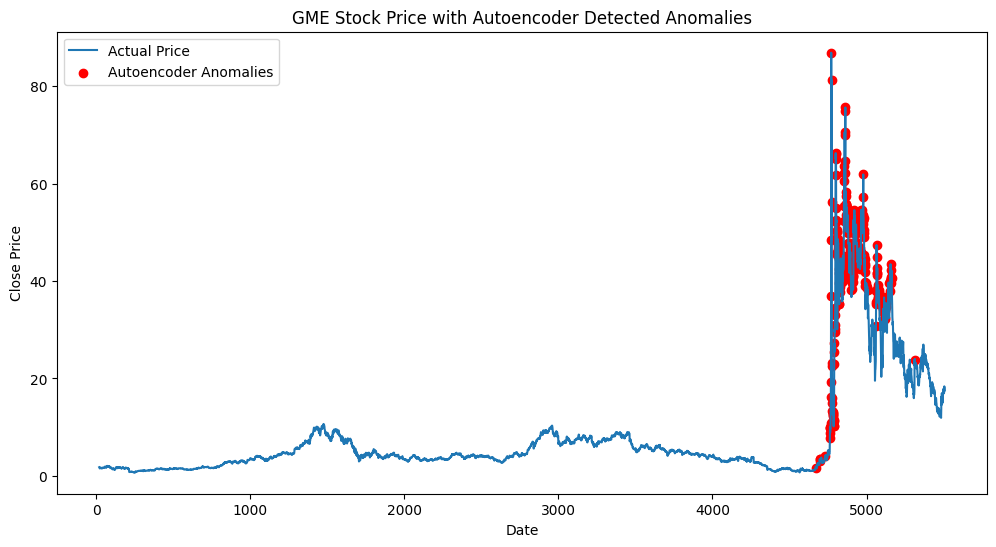

Number of Autoencoder Detected Anomalies: 275


In [88]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data.index, gme_data['Close'], label='Actual Price')
plt.scatter(gme_data.index[anomalies], 
            gme_data.loc[anomalies, 'Close'], 
            color='red', label='Autoencoder Anomalies')
plt.title('GME Stock Price with Autoencoder Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Print summary of Autoencoder anomalies
print(f"Number of Autoencoder Detected Anomalies: {sum(anomalies)}")

In [89]:
gme_data_copy = gme_data.copy()

# Add Anomaly_Autoencoder column
gme_data_copy['Anomaly_Autoencoder'] = anomalies.astype(int)

# Update the combined anomaly column
gme_data_copy['Combined_Anomaly'] = ((abs(gme_data_copy['Close_Z_Score']) > 3) | 
                                     (gme_data_copy['Anomaly_IsoForest'] == -1) | 
                                     (gme_data_copy['Anomaly_DBSCAN'] == -1) |
                                     (gme_data_copy['Anomaly_Autoencoder'] == 1)).astype(int)

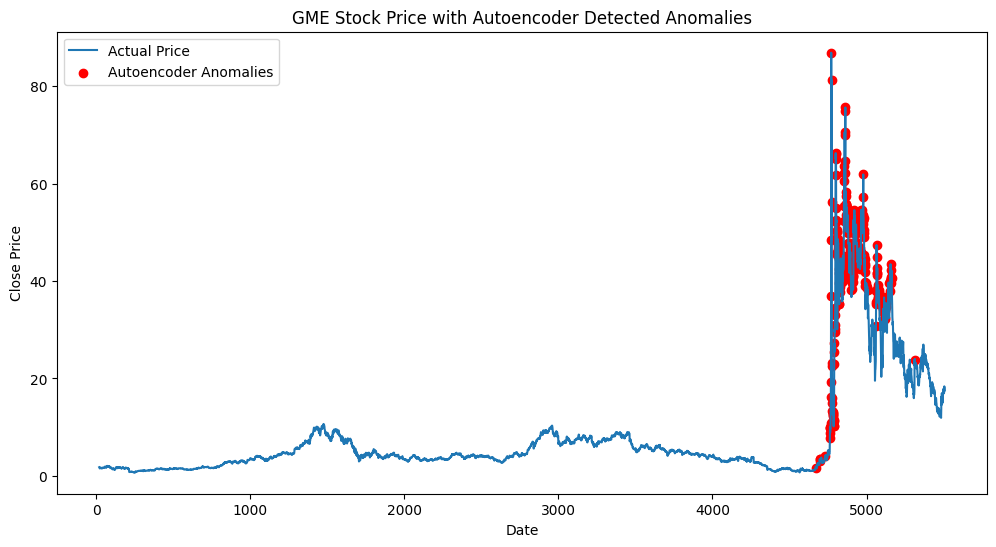

Number of Autoencoder Detected Anomalies: 275

Performance metrics for Autoencoder:
Precision: 1.0000
Recall: 0.6675
F1-Score: 0.8006


In [92]:
plt.figure(figsize=(12, 6))
plt.plot(gme_data_copy.index, gme_data_copy['Close'], label='Actual Price')
plt.scatter(gme_data_copy.index[anomalies], 
            gme_data_copy.loc[anomalies, 'Close'], 
            color='red', label='Autoencoder Anomalies')
plt.title('GME Stock Price with Autoencoder Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Print summary of Autoencoder anomalies
print(f"Number of Autoencoder Detected Anomalies: {sum(anomalies)}")

# Calculate performance metrics for Autoencoder
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(gme_data_copy['Combined_Anomaly'], gme_data_copy['Anomaly_Autoencoder'])
recall = recall_score(gme_data_copy['Combined_Anomaly'], gme_data_copy['Anomaly_Autoencoder'])
f1 = f1_score(gme_data_copy['Combined_Anomaly'], gme_data_copy['Anomaly_Autoencoder'])

print("\nPerformance metrics for Autoencoder:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
[[2679 2678]
 [   0  131]]


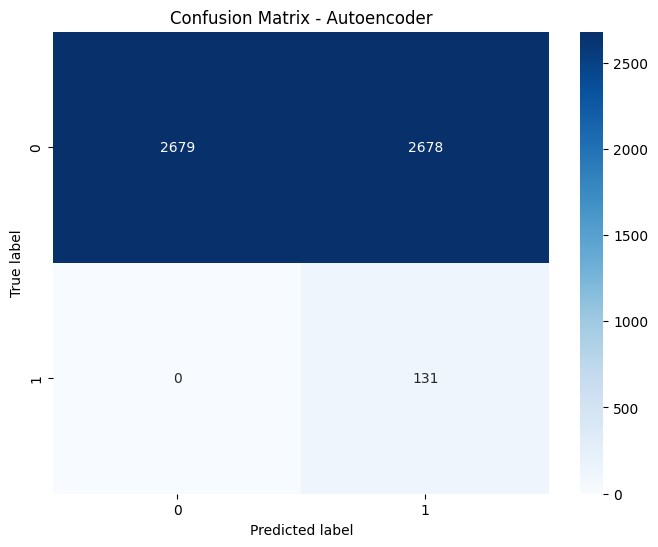

In [95]:


# 1) Isolation Forest anomaly detection
iso = IsolationForest(contamination=0.05, random_state=42)
gme_data['Anomaly_IF'] = iso.fit_predict(gme_data[['Close', 'Volume']])

# 2) Dummy Autoencoder results (replace with your model's output)
# 0 = normal, 1 = anomaly
gme_data['Anomaly_Autoencoder'] = np.random.choice([0,1], size=len(gme_data))

# 3) Combine anomalies (example rule: IF + Autoencoder agree)
gme_data['Combined_Anomaly'] = (
    (gme_data['Anomaly_IF'] == -1) & (gme_data['Anomaly_Autoencoder'] == 1)
).astype(int)

# 4) Confusion Matrix
cm = confusion_matrix(gme_data['Combined_Anomaly'], gme_data['Anomaly_Autoencoder'])
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Autoencoder')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [96]:
methods = ['Z_Score', 'IsoForest', 'DBSCAN', 'Autoencoder']
results = []

for method in methods:
    if method == 'Z_Score':
        predictions = (abs(gme_data['Close_Z_Score']) > 3).astype(int)
    elif method == 'IsoForest':
        predictions = (gme_data['Anomaly_IsoForest'] == -1).astype(int)
    elif method == 'DBSCAN':
        predictions = (gme_data['Anomaly_DBSCAN'] == -1).astype(int)
    else:  # Autoencoder
        predictions = gme_data['Anomaly_Autoencoder']
    
    precision = precision_score(gme_data['Combined_Anomaly'], predictions)
    recall = recall_score(gme_data['Combined_Anomaly'], predictions)
    f1 = f1_score(gme_data['Combined_Anomaly'], predictions)
    
    results.append({
        'Method': method,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nComparison of all methods:")
print(results_df)


Comparison of all methods:
        Method  Precision    Recall  F1-Score
0      Z_Score   0.293532  0.450382  0.355422
1    IsoForest   0.363636  0.152672  0.215054
2       DBSCAN   0.327206  0.679389  0.441687
3  Autoencoder   0.046636  1.000000  0.089116


In [98]:
autoencoder_results = {
    'Method': 'Autoencoder',
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}
autoencoder_df = pd.DataFrame([autoencoder_results])
results_df = pd.concat([results_df, autoencoder_df], ignore_index=True)




Comparison of all methods:
        Method  Precision    Recall  F1-Score
0      Z_Score   0.293532  0.450382  0.355422
1    IsoForest   0.363636  0.152672  0.215054
2       DBSCAN   0.327206  0.679389  0.441687
3  Autoencoder   0.046636  1.000000  0.089116


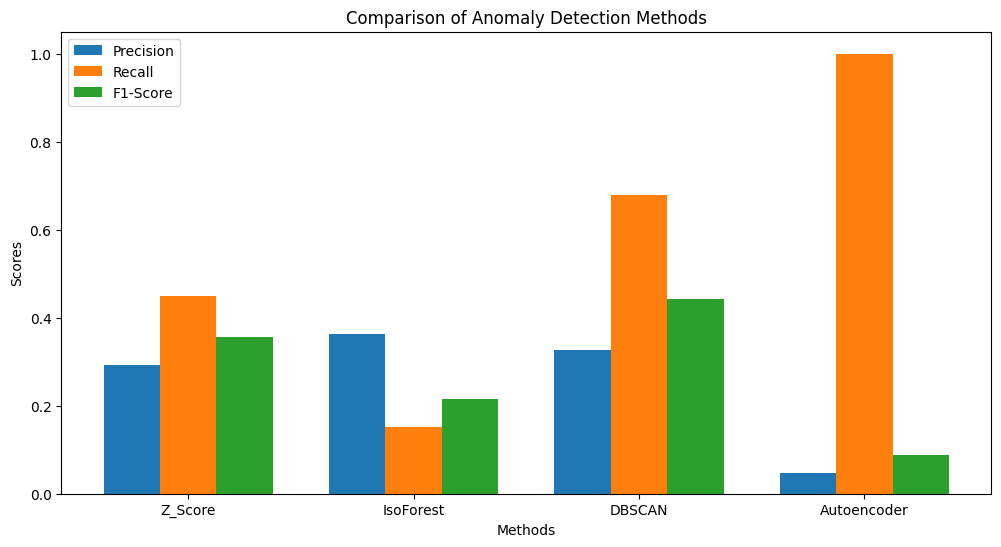

In [99]:
results_df = pd.DataFrame(results)
print("\nComparison of all methods:")
print(results_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(methods))
width = 0.25

plt.bar(x - width, results_df['Precision'], width, label='Precision')
plt.bar(x, results_df['Recall'], width, label='Recall')
plt.bar(x + width, results_df['F1-Score'], width, label='F1-Score')

plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Comparison of Anomaly Detection Methods')
plt.xticks(x, methods)
plt.legend()
plt.show()

In [100]:
gme_data.to_csv("clean_gme_data.csv")